# Example of Human Activity Recognition from accelerometer data using deep learning

This is a brief demo of functions that convert the raw time based accelerometer data and human activity recognition (HAR) labels to trainX, trainy, testX, testy numpy arrays. 
* Builds numpy arrays using load_dataset functions and default arguments
* Builds/Trains/Evaluates a 1D CNN classifier for the selected dataset
* Displays several model evaluation figures and metrics

Authors:  Lee B. Hinkle, Vangelis Metsis, IMICS Lab, Texas State University, 2021

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.



In [1]:
#mount google drive in colab session
from google.colab import drive
drive.mount('/content/drive')

#enter path to where the datasets can be found in google drive
my_path = '/content/drive/MyDrive/Academia/Presentations/AIAI2021 - Biosignal analysis tutorial/Data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Check hardware information (optional)
cpu_model = !grep 'model name' /proc/cpuinfo
header = 'CPU1: ' + cpu_model[0] + '\n'
header += 'CPU2: ' + cpu_model[1] + '\n'
gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
header += 'GPU: ' + str(gpu_info[1]) + '\n'
print(header)

CPU1: model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
CPU2: model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: Tesla T4, 460.32.03, 15109 MiB



#Imports

In [3]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

#Get numpy arrays from load_dataset

Auxiliary functions used to display the shape of the data

In [5]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

The following cell uses the auxiliary script unimib_shar_adl_load_dataset.py to download the UniMiB_SHAR dataset from its original source and converts it into
Numpy arrays for easy processing.

In [10]:
dataset = "UniMiB SHAR"
datasetfn = 'mobiact_adl_load_dataset.py'
full_filename = my_path+'/HAR/UniMiB_SHAR/'+'unimib_shar_adl_load_dataset.py'
shutil.copy(full_filename,'unimib_shar_adl_load_dataset.py')

from unimib_shar_adl_load_dataset import unimib_load_dataset
#x_train, y_train, x_test, y_test = unimib_load_dataset(incl_val_group = False)
x_train, y_train, x_validate, y_validate, x_test, y_test = unimib_load_dataset(incl_val_group = True)
t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']

print(get_shapes([x_train, y_train, x_validate, y_validate, x_test, y_test]))

Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
Reshaped data    shape           object type              data type
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 1)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
x/y_train shape  (4601, 151, 1) (4601,)
x/y_validation shape  (1454, 151, 1) (1454,)
x/y_test shape   (1524, 151, 1) (1524,)
After one-hot encoding
x/y_train shape  (4601, 151, 1) (4601, 9)
x/y_validation shape  (1454, 151, 1) (1454, 9)
x/y_test shape   (1524, 151, 1) (1524, 9)
x_train shape is (4601, 151, 1) data type is float64
y_train shape is (4601, 9) data type 

#Build a 1D CNN model
topology and good article
[here](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)

In [7]:
#topology and good article here
#https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
if (True):
	n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
	model = keras.Sequential(
		[
			keras.Input(shape=(n_timesteps,n_features)),
			layers.Conv1D(filters=100, kernel_size=50, activation='relu'),
			layers.Conv1D(filters=100, kernel_size=50, activation='relu'),
			layers.Dropout(0.5),
			layers.MaxPooling1D(pool_size=2),
			layers.Flatten(),
			layers.Dense(100, activation='relu'),
			layers.Dense(n_outputs, activation='softmax')
   		]
	)
	model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 102, 100)          5100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 53, 100)           500100    
_________________________________________________________________
dropout (Dropout)            (None, 53, 100)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 100)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2600)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               260100    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 9

#Train the model

In [8]:
BATCH_SIZE = 32     # Typical values are 8, 16 or 32
NUM_EPOCHS = 30     # How many epochs to train the deep learning model

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(
        x_train,y_train,
        steps_per_epoch=x_train.shape[1]//BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_data=(x_validate,y_validate),
        validation_steps=x_validate.shape[1]//BATCH_SIZE)

Epoch 1/30
4/4 [==============================] - 4s 343ms/step - loss: 4.9953 - accuracy: 0.2236 - val_loss: 1.9103 - val_accuracy: 0.4656
Epoch 2/30
4/4 [==============================] - 0s 48ms/step - loss: 1.7466 - accuracy: 0.4101 - val_loss: 1.6711 - val_accuracy: 0.4305
Epoch 3/30
4/4 [==============================] - 0s 47ms/step - loss: 1.5166 - accuracy: 0.4797 - val_loss: 1.4500 - val_accuracy: 0.6259
Epoch 4/30
4/4 [==============================] - 0s 46ms/step - loss: 1.2790 - accuracy: 0.5847 - val_loss: 1.2610 - val_accuracy: 0.6541
Epoch 5/30
4/4 [==============================] - 0s 48ms/step - loss: 1.1285 - accuracy: 0.6333 - val_loss: 1.1228 - val_accuracy: 0.6747
Epoch 6/30
4/4 [==============================] - 0s 47ms/step - loss: 1.0142 - accuracy: 0.6570 - val_loss: 1.0657 - val_accuracy: 0.6596
Epoch 7/30
4/4 [==============================] - 0s 48ms/step - loss: 0.9862 - accuracy: 0.6494 - val_loss: 1.0169 - val_accuracy: 0.6678
Epoch 8/30
4/4 [==========

#Show Final Validation Accuracy and Loss Curve 

UniMiB SHAR 1D CNN
Final Validation Accuracy: 0.889


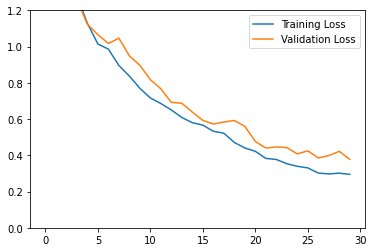

In [11]:
print(dataset, "1D CNN")
print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylim([0,1.2]) #set limit - 1.2 has been a good value experimentally
plt.legend()
plt.show()

# Run the model - predict using the test data

Prediction accuracy: 0.877
              precision    recall  f1-score   support

StandingUpFS       0.64      0.62      0.63        34
StandingUpFL       0.62      0.32      0.42        47
     Walking       0.90      0.90      0.90       344
     Running       0.96      1.00      0.98       413
    GoingUpS       0.72      0.92      0.81       184
     Jumping       0.97      0.90      0.93       146
  GoingDownS       0.95      0.88      0.91       256
 LyingDownFS       0.52      0.47      0.50        68
 SittingDown       0.75      0.66      0.70        32

    accuracy                           0.88      1524
   macro avg       0.78      0.74      0.75      1524
weighted avg       0.88      0.88      0.87      1524



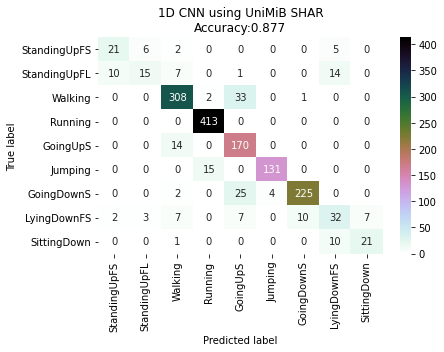

In [12]:
predictions = model.predict(x_test, verbose=0,batch_size=32)

#must use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding

# Print print prediction accuracy
print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))

# Print a report of classification performance metrics
print(classification_report(y_test_act, y_pred, target_names=t_names))

# Plot a confusion matrix
cm = confusion_matrix(y_test_act, y_pred)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()